In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
!conda env list

# conda environments:
#
GoogEarthEngine          /home/jp/miniconda2/envs/GoogEarthEngine
astroconda               /home/jp/miniconda2/envs/astroconda
everest-pipeline         /home/jp/miniconda2/envs/everest-pipeline
helios                   /home/jp/miniconda2/envs/helios
iraf27                   /home/jp/miniconda2/envs/iraf27
ircs_pol                 /home/jp/miniconda2/envs/ircs_pol
moscatel                 /home/jp/miniconda2/envs/moscatel
radmc3dpy                /home/jp/miniconda2/envs/radmc3dpy
root                  *  /home/jp/miniconda2



# Dipper (sub-)list

The links below show the quick look lightcurve reduced using a K2 data pipeline called [K2SFF](https://archive.stsci.edu/prepds/k2sff/) available online.

* [EPIC203824153](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203824153.html)
* [EPIC203937317](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203937317.html)
* [EPIC204278916](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204278916.html)
* [EPIC204469637](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204469637.html)
* [EPIC204514548](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204514548.html)
* [EPIC204630363](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204630363.html)
* [EPIC204638512](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204638512.html)
* [EPIC205151387](https://www.cfa.harvard.edu/~avanderb/k2c2/ep205151387.html)
* [EPIC203843911](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203843911.html)

## Corrected lightcurves from Vanderburg website

* [campaign 2](https://www.cfa.harvard.edu/~avanderb/k2c2/)


* DF is a dictionary of dataframes
* df is a merged DF

* DF1 has no index while DF2 has the time (BJD) as index
* df2 is a merged DF2

The advantage of this approach over using everest-pipeline is that direct download of corrected lightcurve is possible, making analysis relatively quickly. Take caution however that the pipeline might remove inherent variability in the dipper lightcurve so study how the pipeline exactly does the correction. 

In [1]:
epics='''203824153
203937317
204278916
204469637
204514548
204630363
204638512
205151387
203843911'''.split('\n')

In [2]:
import pandas as pd

campaign=str(2)
part1='http://archive.stsci.edu/missions/hlsp/k2sff/c0'
part2='00000/'
part3='/hlsp_k2sff_k2_lightcurve_'
part4='_kepler_v1_llc-default-aper.txt'


DF = {}
for epic in epics:
    try:
        url=part1+campaign+'/'+epic[:4]+part2+epic[-5:]+part3+epic+'-c0'+campaign+part4
        print('downloading: {}'.format(epic))
        #save in dict
        DF[epic] = pd.read_csv(url, sep=",", header=0, index_col=False)
        #save locally as csv
        #fname=epic+'_lc_vanderburg.csv'
        #DF[epic].to_csv(fname)
    except Exception as e:
        print('{0}: {1}'.format(epic, e))

downloading: 203824153
downloading: 203937317
downloading: 204278916
downloading: 204469637
downloading: 204514548
downloading: 204630363
downloading: 204638512
downloading: 205151387
downloading: 203843911


In [4]:
DF.keys()

['204630363',
 '203937317',
 '204469637',
 '204278916',
 '203824153',
 '205151387',
 '204638512',
 '204514548',
 '203843911']

In [5]:
ep363=DF[DF.keys()[0]]
ep363.head()

,BJD - 2454833,Corrected Flux
0,2061.305537,1.009036
1,2061.325969,1.009801
2,2061.346401,1.010715
3,2061.366833,1.011483
4,2061.387265,1.011459


In [6]:
DF2 = {}
for key in DF.keys():
    DF2[key] = DF[key].set_index(keys=DF[key].columns[0])
    DF2[key].columns = [key]

In [8]:
frames = []
for key in DF2.keys():
    frames.append(DF2[key])
    
df = pd.concat(frames, axis=1)
df.columns

Index([u'204630363', u'203937317', u'204469637', u'204278916', u'203824153',
       u'205151387', u'204638512', u'204514548', u'203843911'],
      dtype='object')

In [9]:
for key in df.columns:
    print('{0}: {1}'.format(key, len(df[str(key)].dropna())))

204630363: 3246
203937317: 3253
204469637: 3307
204278916: 3302
203824153: 3210
205151387: 3307
204638512: 3263
204514548: 3225
203843911: 3241


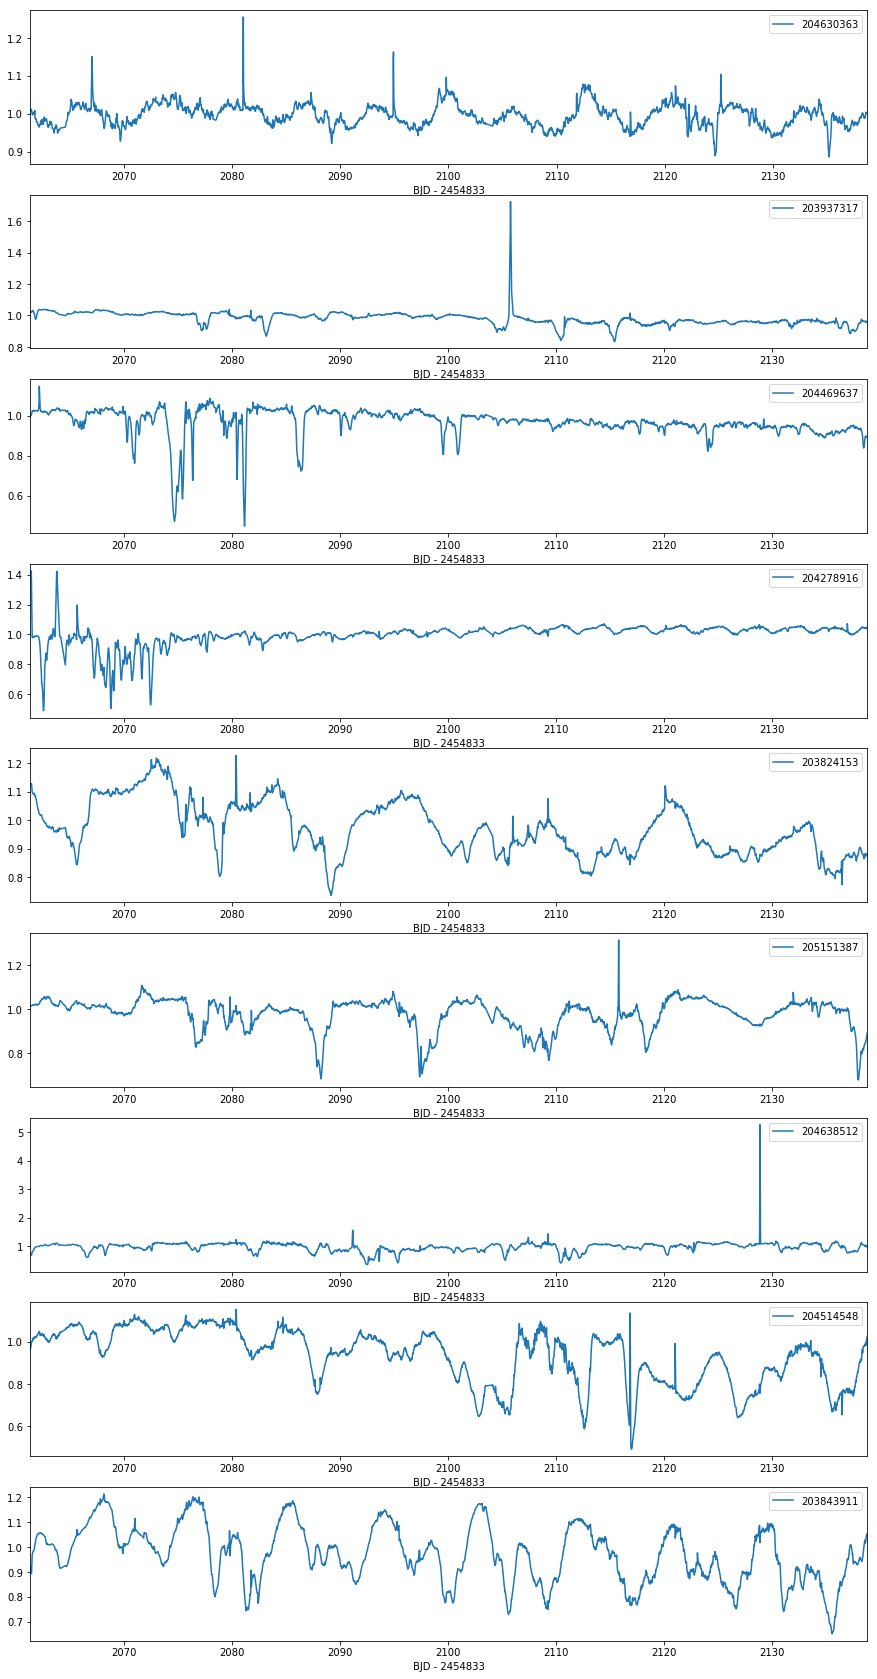

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=len(df.columns),ncols=1, figsize=(15,30))
for i,j in enumerate(df.columns):
    df[str(j)].dropna().plot(ax=ax[i], legend=True)

## modeling

### PyTransit for fitting lightcurve

In [13]:
import pytransit as pt

In [22]:
import numpy as np
from pytransit import MandelAgol

t = np.linspace(0.8,1.2,500)
k, t0, p, a, i, e, w = 0.1, 1.01, 4, 8, 0.48*np.pi, 0.2, 0.5*np.pi
#u = [0.25,0.10]
u = [[0.25, 0.1],[0.35,0.2],[0.45,0.3],[0.55,0.4]]

pv = [k, u, t0, p, a, i, e, w]

m = MandelAgol()
f = m.evaluate(t, *pv)

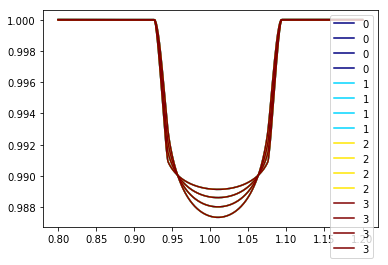

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib.pyplot import cm 

n = len(u)
color=plt.cm.jet(np.linspace(0,1,n))

for i,c in zip(range(n),color):
    plt.plot(t,f,'-',color=c, label=i);
plt.legend(loc='best')

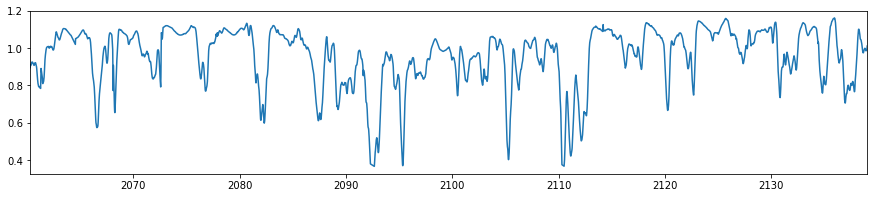

In [6]:
#remove outliers
sigma=3
EPIC512=df.EPIC512[np.abs(df.EPIC512-df.EPIC512.mean())<=(sigma*df.EPIC512.std())]
#normalize
EPIC512/=np.nanmedian(df.EPIC512)
EPIC512.plot(figsize=(15,3));

In [302]:
EPIC512.head()

2060.283833    0.895616
2060.304265    0.905298
2060.324698    0.908722
2060.345129    0.907807
2060.365562    0.912496
Name: EPIC512, dtype: float64

In [317]:
df.keys()

Index([u'EPIC153', u'EPIC317', u'EPIC916', u'EPIC548', u'EPIC637', u'EPIC363',
       u'EPIC512', u'EPIC387', u'EPIC911'],
      dtype='object')

In [335]:
EPIC512=pd.DataFrame(df.EPIC512)
EPIC512.head()
t= EPIC512.dropna().index
f=EPIC512.EPIC512.dropna().values
f

array([ 0.89561583,  0.90529845,  0.90872236, ...,  0.99336231,
        0.99910706,  1.0112849 ])

(0, 0.1)

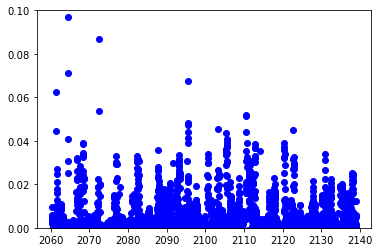

In [340]:
plt.plot(t[:-1],np.diff(f),'bo')
plt.ylim(0,0.1)

In [341]:
!pip install peakutils

  Running setup.py bdist_wheel for peakutils ... done
  Stored in directory: /home/jp/.cache/pip/wheels/cb/17/d9/ae7f621c1e24ce2e4da18ca9f01b032f4474bb1b04822d886e
Successfully built peakutils


In [355]:
import peakutils as pu
from peakutils.plot import plot as pplot 

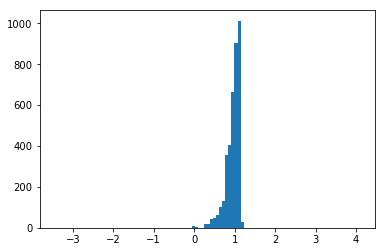

In [382]:
plt.hist(f,bins=100);

(0, 1.2)

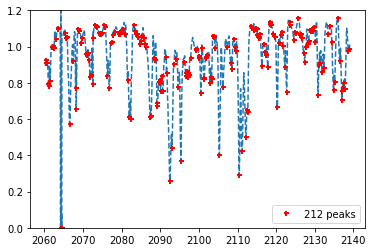

In [376]:
peaks = pu.indexes(1.3-f, thres=0.3, min_dist=3)
pplot(t,f,peaks)
plt.ylim(0,1.2)

array([   3,   10,   18,   39,   48,   58,   88,   95,  105,  133,  189,
        192,  195,  198,  201,  203,  260,  265,  301,  304,  348,  375,
        383,  447,  456,  508,  513,  518,  534,  543,  558,  564,  592,
        599,  679,  681,  684,  687,  690,  775,  797,  822,  827,  830,
        835,  838,  849,  851,  924,  928,  995, 1027, 1048, 1064, 1137,
       1145, 1147, 1161, 1180, 1183, 1195, 1210, 1233, 1245, 1249, 1258,
       1312, 1322, 1358, 1365, 1396, 1401, 1421, 1424, 1427, 1433, 1441,
       1455, 1470, 1508, 1515, 1557, 1584, 1607, 1635, 1663, 1696, 1732,
       1754, 1764, 1770, 1772, 1782, 1791, 1796, 1816, 1880, 1890, 1919,
       1927, 1945, 1963, 1983, 1989, 2005, 2010, 2027, 2060, 2073, 2080,
       2098, 2105, 2112, 2125, 2178, 2224, 2277, 2320, 2335, 2356, 2368,
       2371, 2373, 2384, 2426, 2462, 2509, 2524, 2533, 2655, 2665, 2673,
       2677, 2688, 2710, 2736, 2738, 2750, 2754, 2757, 2761, 2783, 2852,
       2870, 2900, 2925, 2929, 2948, 2975, 2993, 30

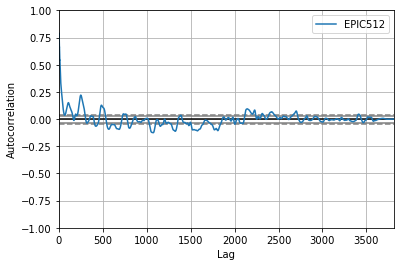

In [7]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.EPIC512.dropna(), label='EPIC512');

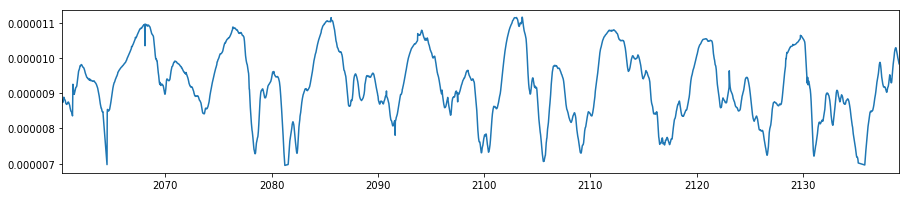

In [49]:
#remove outliers
sigma=1
EPIC911=df.EPIC911[np.abs(df.EPIC911-df.EPIC911.mean())<=(sigma*df.EPIC911.std())]/np.nanmedian(df.EPIC911)
# normalize
EPIC911/=np.nanmedian(df.EPIC911)
EPIC911.plot(figsize=(15,3));

this is probably thruster firings!

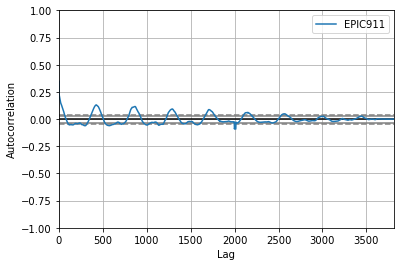

In [51]:
autocorrelation_plot(df.EPIC911.dropna(), label='EPIC911');

To classify the periodicity, we fit a hyperbolic secant function with time varying dip depths to each light curve:
$$
y = F_0 - \sum_n 2D(t_n) \times \Big[\exp \Big(\frac{t-t_n}{\tau}\Big) +\exp \Big(-\frac{t-t_n}{\tau} \Big)\Big]^{-1}
$$
where $t_n = t_0+nP_{rot}$

* $F_0$ is the baseline flux level
* $t_0$ is the location of the first dip in the light curve
* $n$ is the dip number
* $P_{rot}$ is the inferred rotation period (assumed to be fixed)
* $\tau$ is the dip duration
* $D(t_n)$ is the depth of dip n

Try Levenberg–Marquardt technique for $\chi^2$ minimization.

In [116]:
def sech(x,A):
    return A/np.cosh(x)

def sech2(x,A):
    return 2.0*A/(np.exp(x)+np.exp(-x))

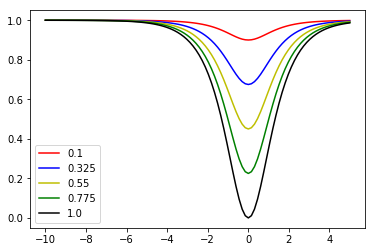

In [204]:
tau = 1
t0 = 5
Prot = 10
dips = 2
#tn = t0+n*Prot

t = np.linspace(-t0,Prot, 100)
x = (t-t0)/tau

y = []
B = 1.0 #baseline
dips = np.linspace(0.1,1,5) #dip depth

y = {}
for n, A in enumerate(dips):
    y[n]=[]
    for i in x:
        yi = B-sech2(i,A)
        y[n].append(yi)
        
c='r,b,y,g,k,c'.split(',')

for i,j in enumerate(dips):
    plt.plot(x,y[i],'r-',color=c[i], label=j);
plt.legend(loc='best')

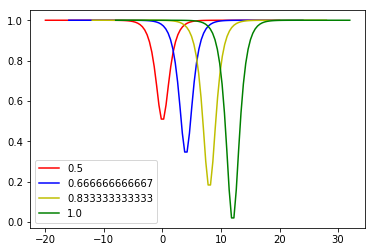

In [300]:
tau = 0.1
t0 = 2.0
Prot = 4.0
B = 1.0 #baseline

dips = np.linspace(0.5,1,4) #dip depth

y = {}
x = {}
t=[0]
for n, A in enumerate(dips):
    y[n]=[]
    t = np.linspace(t[-1],(n+1)*Prot, 100)
    #print(t)
    x = (t-(t0+n*Prot))/tau
    for i in x:
        yi = B-sech2(i,A)
        y[n].append(yi)
        
c='r,b,y,g,k,c'.split(',')

for i,j in enumerate(dips):
    plt.plot(i*Prot+x,y[i],'r-',color=c[i], label=j);
    #plt.xlim(x[i][0],x[i][-1])
plt.legend(loc='best')

In [227]:
df.keys()

Index([u'EPIC153', u'EPIC317', u'EPIC916', u'EPIC548', u'EPIC637', u'EPIC363',
       u'EPIC512', u'EPIC387', u'EPIC911'],
      dtype='object')

In [61]:
dipper = df.EPIC512

In [62]:
#normalize
dipper/=np.nanmedian(dipper)

In [63]:
dipper.head()

2060.283697         NaN
2060.283812         NaN
2060.283833    0.895616
2060.283854         NaN
2060.283931         NaN
Name: EPIC512, dtype: float64

In [64]:
np.nanmedian(dipper)

1.0

In [ ]:
def secant(F0, D, t, tn, tau):
    t_scaled = (t - tn)/tau
    factor = np.exp(t_scaled)+np.exp(-t_scaled)
    y = F0 - 2*D*1.0/factor
    return y

In [ ]:
#count dips

#measure depth of dip n
D = []

#measure dip duration
tau = []

time until flux ~ median flux

In [ ]:
#constants
F0 = np.nanmedian(dipper) #1 if normalized
Prot = 49.23 #based on L-S periodogram
time = dipper.index

f=[]
for t in time:
    for idx,dip in enumerate(dips):
        t_n = t0 + n*Prot
        f_i = secant(F0, dip, t, tn, tau[idx])
        f.append(f_i)

## Phase-folding: Lomb-Scargle Periodogram

In [16]:
import gatspy
from gatspy.periodic import LombScargleFast

periods={}
powers ={}
for i in df.columns:
    t, f = df[str(i)].dropna().index, df[str(i)].dropna()
    model = LombScargleFast().fit(t, f)
    periods[str(i)], powers[str(i)] = model.periodogram_auto(nyquist_factor=100)

In [17]:
periods.keys()

['EPIC363',
 'EPIC317',
 'EPIC916',
 'EPIC637',
 'EPIC153',
 'EPIC911',
 'EPIC512',
 'EPIC387',
 'EPIC548']

In [18]:
#determine peak period in each lightcurve
for j,key in enumerate(periods.keys()):
    idx1 = periods[key] > 1.0
    idx2 = np.argmax(powers[key][idx1])
    peak = periods[key][idx1][idx2]
    print('{0}: {1:.2f} d'.format(key,peak))

EPIC363: 6.56 d
EPIC317: 2.72 d
EPIC916: 7.57 d
EPIC637: 393.82 d
EPIC153: 12.31 d
EPIC911: 8.95 d
EPIC512: 49.23 d
EPIC387: 10.10 d
EPIC548: 393.82 d


EPIC637 and EPIC548 have anomalously long "periods"

/home/jp/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


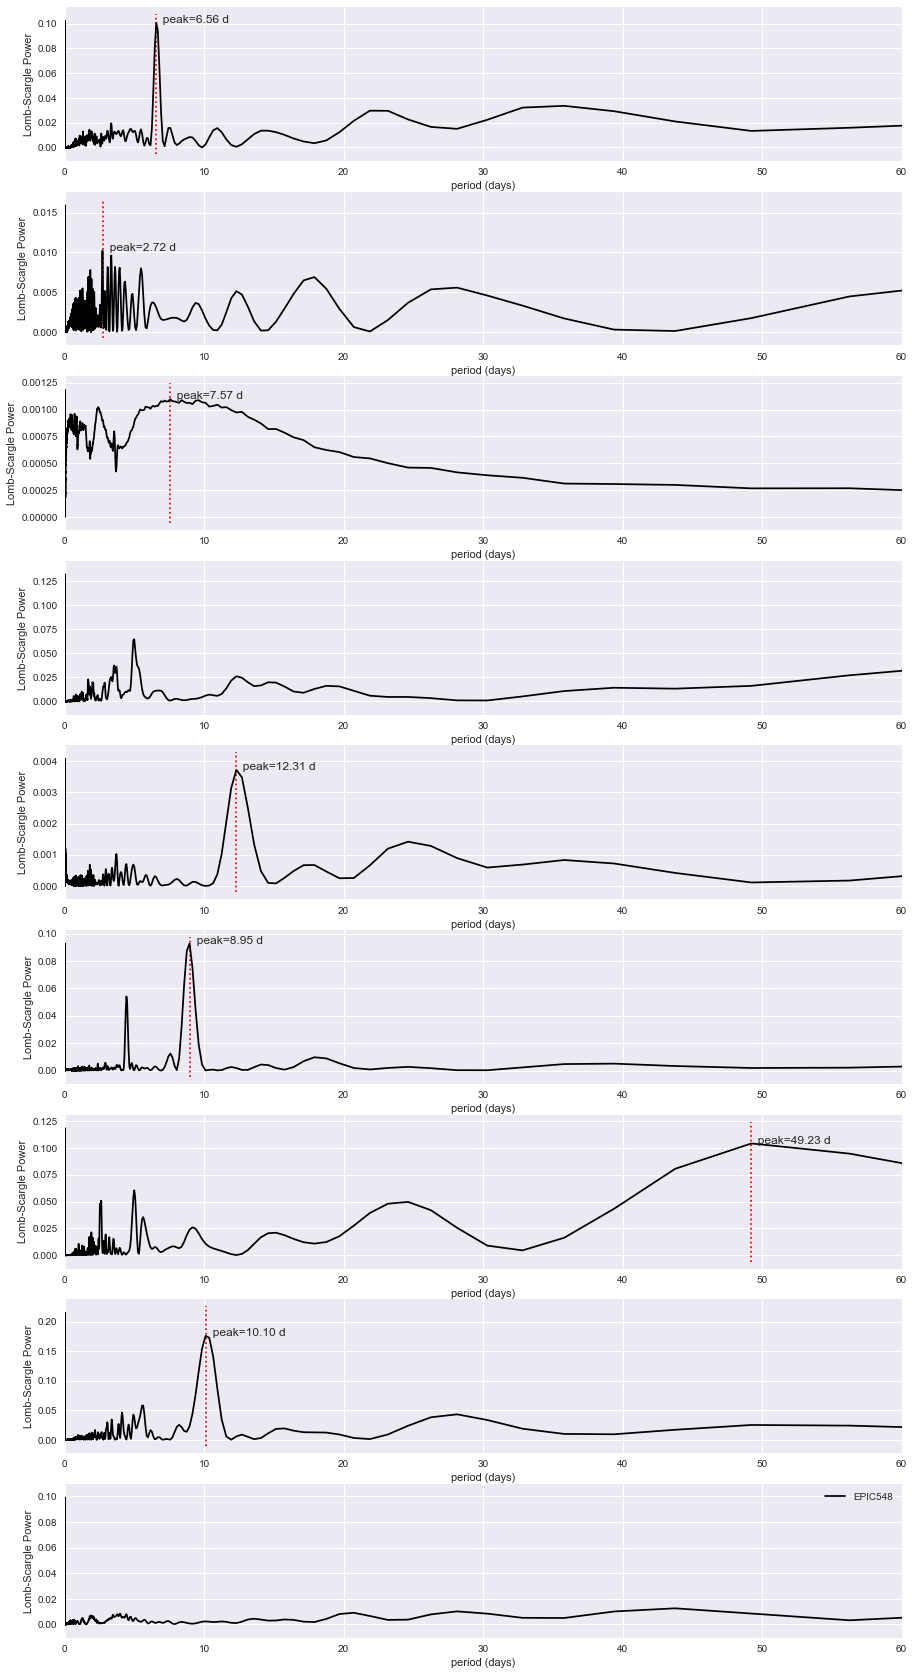

In [19]:
import seaborn as sb

fig, ax = plt.subplots(nrows=9,ncols=1,figsize=(15,30))

for j,key in enumerate(periods.keys()):
    idx1 = periods[key] > 1.0
    idx2 = np.argmax(powers[key][idx1])
    peak = periods[key][idx1][idx2]
    try:
        with sb.axes_style('white'):
            ax[j].plot(periods[key], powers[key], 'k-', label=key)
            
            xlim=60
            ax[j].set(xlim=(0, xlim),
        #         , ylim=(0, 0.01),
               xlabel='period (days)',
               ylabel='Lomb-Scargle Power')
            ax[j].vlines(peak, *ax[j].get_ylim(), linestyles='dotted', colors='r')
            if  peak < xlim:
                ax[j].text(peak, powers[key][idx1][idx2], '  peak={0:.2f} d'.format(peak))
        plt.legend()
    except:
        pass